In [1]:
import pysis.flowsheet as sim_f
from scipy import optimize
import pandas as pd
import sklearn
import scipy
import sklearn.ensemble as forest
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics as metrics
import sklearn.gaussian_process as kriging
import seaborn as sns
from tensorflow import keras
from sklearn import preprocessing
from sklearn.pipeline import Pipeline, TransformerMixin, FeatureUnion
from sklearn.preprocessing import *
from feature_engine import wrappers,outliers

# from feature_engine import
from sklearn.compose import ColumnTransformer
from sklearn import model_selection
from sklearn.gaussian_process import GaussianProcessRegressor
from feature_engine.creation import MathFeatures, RelativeFeatures
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFECV
import optuna
import json
import pickle
import pyswarm
import pygad
import seaborn as sns 
import SimulacaoCalc
import Regressor

c:\Users\LuanNogs\Documents\Ic-Metamodelagem\luanvenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy
import json
import pandas as pd 

from sklearn.model_selection import train_test_split


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,RobustScaler,FunctionTransformer,MinMaxScaler,PolynomialFeatures

# Carregar X
with open(r'lhs_samples.json','r') as file:
    lhs_samples=json.load(file)
with open(r'random_lhs_samples.json','r') as file:
    random_lhs_samples=json.load(file)

x=pd.DataFrame(lhs_samples).transpose()
x.set_index(x.index.astype(int))

random_x=pd.DataFrame(random_lhs_samples).transpose()
random_x.set_index(x.index.astype(int))
# Carregar Y
with open('ydados2.json','r') as file:
    y=json.load(file)
with open('yrandomdados2.json','r') as file:
    random_y=json.load(file)

y=pd.DataFrame(y).transpose()
y_random=pd.DataFrame(random_y).transpose()
y.set_index(y.index.astype(int))


y_random=y_random.set_index(y_random.index.astype(int))
y=y.set_index(y.index.astype(int))
x=x.set_index(x.index.astype(int))
random_x=random_x.set_index(random_x.index.astype(int))

union_index=[i for i in list(y.index) if i in list(y_random.index)]

y=y.loc[union_index]

y_random=y_random.loc[union_index]

random_x=random_x.loc[union_index]

x=x.loc[union_index]

false_index=(y.loc[((y['Convergencia_correntes']==False) | (y_random['Convergencia_correntes']==False))]).index

x.drop(index=false_index,inplace=True)
random_x.drop(index=false_index,inplace=True)
y.drop(index=false_index,inplace=True)
y_random.drop(index=false_index,inplace=True)


y_random=y_random.join(pd.DataFrame(y_random['AreaTC'].to_dict()).transpose().add_prefix('a_tc')).drop('AreaTC',axis=1)
y_random=y_random.join(pd.DataFrame(y_random['PotenciaCompressores'].to_dict()).transpose().add_prefix('p_comp')).drop('PotenciaCompressores',axis=1)
y_random=y_random.join(pd.DataFrame(y_random['MassaProcessVessel'].to_dict()).transpose().add_prefix('m_vessel_')).drop('MassaProcessVessel',axis=1)
y=y.join(pd.DataFrame(y['AreaTC'].to_dict()).transpose().add_prefix('a_tc')).drop('AreaTC',axis=1)
y=y.join(pd.DataFrame(y['PotenciaCompressores'].to_dict()).transpose().add_prefix('p_comp')).drop('PotenciaCompressores',axis=1)
y=y.join(pd.DataFrame(y['MassaProcessVessel'].to_dict()).transpose().add_prefix('m_vessel_')).drop('MassaProcessVessel',axis=1)

y_relative_error=((y-y_random)/y.replace(0.0,numpy.nan)).add_suffix('_erro',axis=1)
y_absolute_error=(y-y_random).add_suffix('_absolute_error',axis=1)

y=y.astype(float)
x=x.astype(float)
index_to_drop=y_relative_error.loc[y_relative_error['Lucro_erro'].abs()>0.1].index
y.drop(index=index_to_drop,inplace=True)
y_random.drop(index=index_to_drop,inplace=True)
x.drop(index=index_to_drop,inplace=True)
random_x.drop(index=index_to_drop,inplace=True)

y.sort_index()
y_random.sort_index()

y_mean=(y['Lucro']+y_random['Lucro'])/2
df=x.join(y)



df=df.astype(float)
var=[0,1,2,3,4,5,'Lucro']
dft=df[var]

dft.rename({0:'Temperatura de Reação',1:'Vazão de H2',2:'Razão de Purga',3:'Razão de Reciclo',4:'Volume do Reator',5: 'Vazão de CO2'},axis=1,inplace=True)


dft.reset_index(drop=True,inplace=True)
dof=['Temperatura de Reação','Vazão de H2','Razão de Purga','Razão de Reciclo','Volume do Reator','Vazão de CO2']
# dft.drop(index=(dft.loc[dft['Lucro']<2000]).index,inplace=True)
bins = numpy.linspace(0, 23200, 15)
y_binned = numpy.digitize(dft['Lucro'], bins)

X_train,X_test,y_train, y_test = train_test_split(dft[dof],dft['Lucro'], test_size=0.2, shuffle=True,random_state=5)

C:\Users\LuanNogs\AppData\Local\Temp\ipykernel_13424\3317723037.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft.rename({0:'Temperatura de Reação',1:'Vazão de H2',2:'Razão de Purga',3:'Razão de Reciclo',4:'Volume do Reator',5: 'Vazão de CO2'},axis=1,inplace=True)


<Axes: >

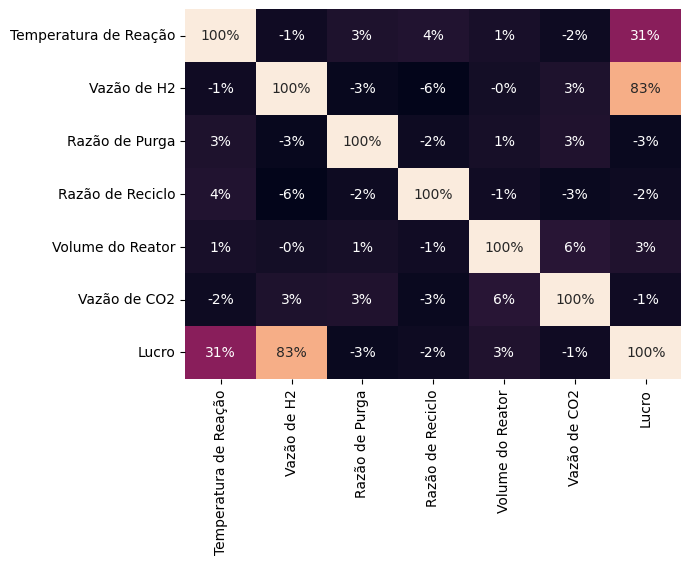

In [22]:
import seaborn

seaborn.heatmap(dft.corr()*100,annot=dft.corr(),fmt='.0%',cbar=False)

In [13]:
dft.corr()*100

,Temperatura de Reação,Vazão de H2,Razão de Purga,Razão de Reciclo,Volume do Reator,Vazão de CO2,Lucro
Temperatura de Reação,100.000000,-1.258133,2.624134,3.508235,1.266077,-1.933542,30.838618
Vazão de H2,-1.258133,100.000000,-3.382205,-5.729549,-0.100970,2.890740,83.288812
Razão de Purga,2.624134,-3.382205,100.000000,-1.903163,0.779925,3.009563,-2.997592
Razão de Reciclo,3.508235,-5.729549,-1.903163,100.000000,-0.839716,-3.107048,-1.934418
Volume do Reator,1.266077,-0.100970,0.779925,-0.839716,100.000000,5.748470,3.063618
Vazão de CO2,-1.933542,2.890740,3.009563,-3.107048,5.748470,100.000000,-1.305560
Lucro,30.838618,83.288812,-2.997592,-1.934418,3.063618,-1.305560,100.000000


Otimização PSO


In [7]:
with open(r'pipeline_model.pickle','rb') as file:
    models=pickle.load(file)
    file.close()
simulation_opt_results={}
opt_results={}
x_optimal={}
# x0=Regressor.Regressor(dft,'Lucro')
for name,model in models.items():
    fun=lambda x:-model.predict(numpy.array(x).reshape(1,-1))
    
    l_bounds = [180, 4500, 0.001, 1.25, 35, 4500]
    u_bounds = [240, 6500, 0.05, 1.8, 55, 5500]
    pso=pyswarm.pso(fun,lb=l_bounds,ub=u_bounds,debug=True,maxiter=50,swarmsize=50)
    simulation_opt_results.update({name:pso})
sim_opt={}
sim=SimulacaoCalc.SimulationOps(r'C:\Users\LuanNogs\Documents\Ic-Metamodelagem\Simulações\HidrogenaçãoCO2A.hsc')
for name,result in simulation_opt_results.items():
    sim.set_dof_u(result[0])
    sim_opt.update({name:{'Condição Ótima {} (PSO)'.format(name):result[0],'Simulação':sim.profit(),'PSO':float(result[1])}})
with open(r'pso_optimization.pickle','wb') as file:
    pickle.dump(sim_opt,file)
    

No constraints given.
New best for swarm at iteration 1: [2.37443357e+02 6.50000000e+03 3.74220634e-02 1.80000000e+00
 5.00408713e+01 4.50000000e+03] [-24367.485467]
New best for swarm at iteration 1: [2.21328304e+02 6.50000000e+03 1.62065782e-02 1.55557831e+00
 4.81073666e+01 4.56906235e+03] [-24373.56143938]
Best after iteration 1: [2.21328304e+02 6.50000000e+03 1.62065782e-02 1.55557831e+00
 4.81073666e+01 4.56906235e+03] [-24373.56143938]
New best for swarm at iteration 2: [2.29712258e+02 6.40577609e+03 1.00000000e-03 1.66634388e+00
 4.53921143e+01 4.59317977e+03] [-24389.66016537]
Best after iteration 2: [2.29712258e+02 6.40577609e+03 1.00000000e-03 1.66634388e+00
 4.53921143e+01 4.59317977e+03] [-24389.66016537]
New best for swarm at iteration 3: [2.30358737e+02 6.50000000e+03 1.00000000e-03 1.63645517e+00
 4.54304209e+01 4.50000000e+03] [-24393.87434879]
Best after iteration 3: [2.30358737e+02 6.50000000e+03 1.00000000e-03 1.63645517e+00
 4.54304209e+01 4.50000000e+03] [-24393.8

Optimização Nelder-Mead

In [16]:
with open(r'pipeline_model.pickle','rb') as file:
    models=pickle.load(file)
    file.close()
opt_results={}
x_optimal={}

dof=['Temperatura de Reação','Vazão de H2','Razão de Purga','Razão de Reciclo','Volume do Reator','Vazão de CO2']
x0=dft[dof].loc[dft['Lucro'].idxmax()].values
methods=['Nelder-Mead','BFGS','SLSQP','PSO','Differencial_evolution']
bounds=[(180,240),(4500,6500),(0.001,0.05),(1.25,1.8),(35,55),(4500,5500)]
for name,model in models.items():
    
    fun=lambda x:-(model.predict(np.array(x).reshape(1,6)))  
    res=optimize.minimize(fun,x0,method='Nelder-Mead',tol=1,bounds=bounds,)
    opt_results.update({name:res})
sim=SimulacaoCalc.SimulationOps(r'C:\Users\LuanNogs\Documents\Ic-Metamodelagem\Simulações\HidrogenaçãoCO2A.hsc')
sim_opt={}
for name,result in opt_results.items():
    sim.set_dof(result.x)
    profit=sim.profit()
    
    sim_opt.update({name:{'Condição Ótima {} (Nelder-Mead)'.format(name):result.x,'Simulação':sim.profit(),'Nelder_Mead':float(result.fun)}})
with open(r'Nelder_mead_opt.pickle','wb') as file:
    pickle.dump(sim_opt,file)
    file.close()

1/1 [==============================] - 0s 20ms/step


Amostragem Adaptativa

In [48]:
from sklearn.ensemble import RandomForestRegressor
from pandas import DataFrame
from SimulacaoCalc import SimulationOps
import pyswarm
import pysis
from Regressor import Regressor

Regressor(dft,'Lucro').param_models()

def adaptive_sampling(X:numpy.array,y:numpy.array,model,iterations:int):
    
    
    
    sim=SimulacaoCalc.SimulationOps(r'C:\Users\LuanNogs\Documents\Ic-Metamodelagem\Simulações\HidrogenaçãoCO2A.hsc')
      
    l_bounds = [180, 4500, 0.001, 1.25, 35, 4500]
    u_bounds = [240, 6500, 0.05, 1.8, 55, 5500]
    
    for i in range(iterations):

        
        model.fit(X,y)


        fun=lambda x:-model.predict(numpy.array(x).reshape(1,-1))
        res=optimize.minimize(fun,x0,method='Nelder-Mead',tol=1e-8,bounds=bounds)
        sim.set_dof_u(res.x)
        profit=numpy.array(sim.profit())
        print('simulation_opt: {}'.format(profit)+' optimizer_opt: {}'.format(res.fun))
        
        numpy.append(X,res.x)

        numpy.append(y,profit)

        with open(r'adaptive_sampling_X.pickle','wb') as file:
            pickle.dump(X,file)
            file.close()
        with open(r'adaptive_sampling_y.pickle','wb') as file:
            pickle.dump(y,file)
            file.close()
    pass

        
        
        



        




INFO:tensorflow:Assets written to: C:\Users\LuanNogs\AppData\Local\Temp\tmp7fz8mxfw\assets


INFO:tensorflow:Assets written to: C:\Users\LuanNogs\AppData\Local\Temp\tmp7fz8mxfw\assets


In [50]:

from Regressor import Regressor
Regressor(dft,'Lucro').param_models()
with open(r'models.pickle','rb') as file:
    model=pickle.load(file)
    file.close()
# model['RandomForestRegressor']
adaptive_sampling(X_train.values,y_train.values,model['RandomForestRegressor'],200)


INFO:tensorflow:Assets written to: C:\Users\LuanNogs\AppData\Local\Temp\tmpjykc6t93\assets


INFO:tensorflow:Assets written to: C:\Users\LuanNogs\AppData\Local\Temp\tmpjykc6t93\assets


Epoch 1/500
70/70 [==============================] - 1s 2ms/step - loss: 377493344.0000 - mae: 19110.2637
Epoch 2/500
70/70 [==============================] - 0s 2ms/step - loss: 50872800.0000 - mae: 5557.6187
Epoch 3/500
70/70 [==============================] - 0s 2ms/step - loss: 13271244.0000 - mae: 2904.3337
Epoch 4/500
70/70 [==============================] - 0s 2ms/step - loss: 9698286.0000 - mae: 2469.7173
Epoch 5/500
70/70 [==============================] - 0s 2ms/step - loss: 7821809.0000 - mae: 2208.7317
Epoch 6/500
70/70 [==============================] - 0s 2ms/step - loss: 6493345.5000 - mae: 1970.6604
Epoch 7/500
70/70 [==============================] - 0s 2ms/step - loss: 5718693.5000 - mae: 1882.0110
Epoch 8/500
70/70 [==============================] - 0s 2ms/step - loss: 4810692.0000 - mae: 1702.5654
Epoch 9/500
70/70 [==============================] - 0s 2ms/step - loss: 4415592.5000 - mae: 1618.2585
Epoch 10/500
70/70 [==============================] - 0s 2ms/step - 

KeyboardInterrupt: 

Otimização da Simulação Nelder-mead 

In [153]:

# x0=dft[dof].loc[dft['Lucro'].idxmax()].values
# methods=['Nelder-Mead','BFGS','SLSQP','PSO','Differencial_evolution']
# bounds=[(180,240),(4500,6500),(0.001,0.05),(1.25,1.8),(35,55),(4500,5500)]

# sim=SimulacaoCalc.SimulationOps(r'C:\Users\LuanNogs\Documents\Ic-Metamodelagem\Simulações\HidrogenaçãoCO2A.hsc')
# fun=lambda x:-(sim.func(numpy.array(x)))  
# res=optimize.minimize(fun,x0,method='Nelder-Mead',tol=500,bounds=bounds)
# d={'Otimização Simulação (Nelder-Mead)':res.fun,'Condição Ótima Simulação (Nelder-Mead)':res.x}
with open(r'sim_nelder_mead_opt.pickle','wb') as file:
    pickle.dump(d,file)


Otimização da Simulação PSO

In [11]:
sim=SimulacaoCalc.SimulationOps(r'C:\Users\LuanNogs\Documents\Ic-Metamodelagem\Simulações\HidrogenaçãoCO2A.hsc')

fun=lambda x:-(sim.func(numpy.array(x)))  
pso_simulation_opt_results={}

l_bounds = [180, 4500, 0.001, 1.25, 35, 4500]
u_bounds = [240, 6500, 0.05, 1.8, 55, 5500]
pso=pyswarm.pso(fun,lb=l_bounds,ub=u_bounds,debug=True,maxiter=10,swarmsize=10)
pso_simulation_opt_results.update({'Otimização Simulação (PSO)':pso[1],'Condição Ótima PSO Simulação':pso[0]})
with open(r'sim_pso_opt.pickle','wb') as file:
    pickle.dump(pso_simulation_opt_results,file)


No constraints given.
Resetando Reciclo e correntes
Best after iteration 1: [2.22457993e+02 6.13350700e+03 8.44659118e-03 1.50306162e+00
 4.28295258e+01 5.49807922e+03] -23796.694993526704
New best for swarm at iteration 2: [2.40000000e+02 6.15999427e+03 3.57954318e-02 1.73113925e+00
 3.50000000e+01 5.15499189e+03] -24009.998851277836
New best for swarm at iteration 2: [2.12863758e+02 6.50000000e+03 8.47258144e-03 1.37714074e+00
 4.68559857e+01 5.50000000e+03] -24227.467393815838
Best after iteration 2: [2.12863758e+02 6.50000000e+03 8.47258144e-03 1.37714074e+00
 4.68559857e+01 5.50000000e+03] -24227.467393815838
New best for swarm at iteration 3: [2.21304418e+02 6.50000000e+03 1.22088722e-02 1.32117563e+00
 4.38423971e+01 5.50000000e+03] -24291.836584221863
Best after iteration 3: [2.21304418e+02 6.50000000e+03 1.22088722e-02 1.32117563e+00
 4.38423971e+01 5.50000000e+03] -24291.836584221863
New best for swarm at iteration 4: [2.35820092e+02 6.50000000e+03 1.94581098e-02 1.41712948e+

TypeError: update expected at most 1 argument, got 2

In [23]:
dft['Lucro'].max()

24450.22491815721

2D plot

Text(0.5, 1.0, 'Otimização por PSO')

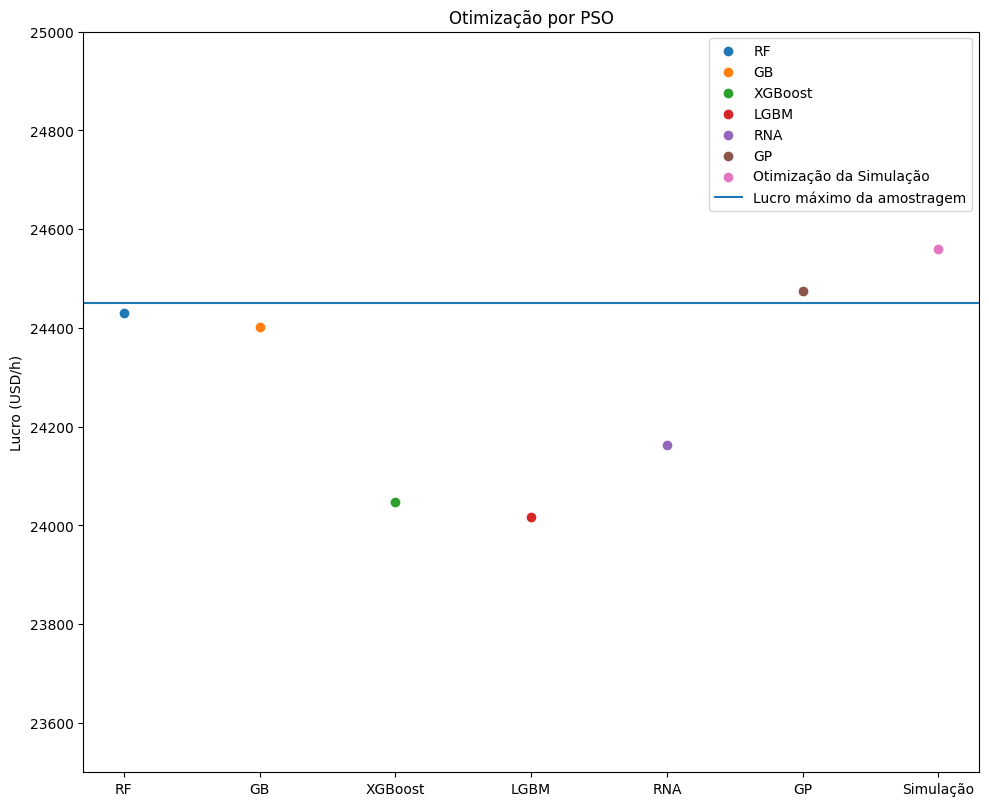

In [32]:
import matplotlib.pyplot as plt
with open(r'pso_optimization.pickle','rb') as file:
    pso_optimization=pickle.load(file) 
with open(r'sim_pso_opt.pickle','rb') as file:
    sim_pso_optimization=pickle.load(file)
fig=plt.figure(figsize=(10,8))
ax=fig.add_subplot()
opt_cond={}
opt_profit={}



for name,result in pso_optimization.items():
    opt_cond.update({name:result['Condição Ótima {} (PSO)'.format(name)]})
    opt_profit.update({name:result['Simulação']})
models_names=['RF','GB','XGBoost','LGBM','RNA','GP']
opt_profit=dict(zip(models_names,opt_profit.values()))
    # opt_cond.update({result['Condição Ótima {} (PSO)'.format(name)]})
for name,profit in opt_profit.items():

    ax.scatter(name,opt_profit['{}'.format(name)],label=name )

    
    # plt.errorbar(name, opt_profit['{}'.format(name)],yerr=[200],fmt='k')
    # ax.annotate('{:.0f}'.format(profit),[name,profit+30],size=20)
ax.scatter('Simulação',-sim_pso_optimization['Otimização Simulação (PSO)'],label='Otimização da Simulação')
# ax.annotate('{:.0f}'.format(-sim_pso_optimization['Otimização Simulação (PSO)']),['Simulação',-sim_pso_optimization['Otimização Simulação (PSO)']+30],size=18)
# plt.errorbar('Simulação', -sim_pso_optimization['Otimização Simulação (PSO)'],yerr=[200],fmt='k')
ax.axhline(y=24450,label='Lucro máximo da amostragem')
ax.set_ylim([23500,25000])
ax.legend()
ax.set_ylabel('Lucro (USD/h)')
fig.tight_layout()
ax.set_title('Otimização por PSO')

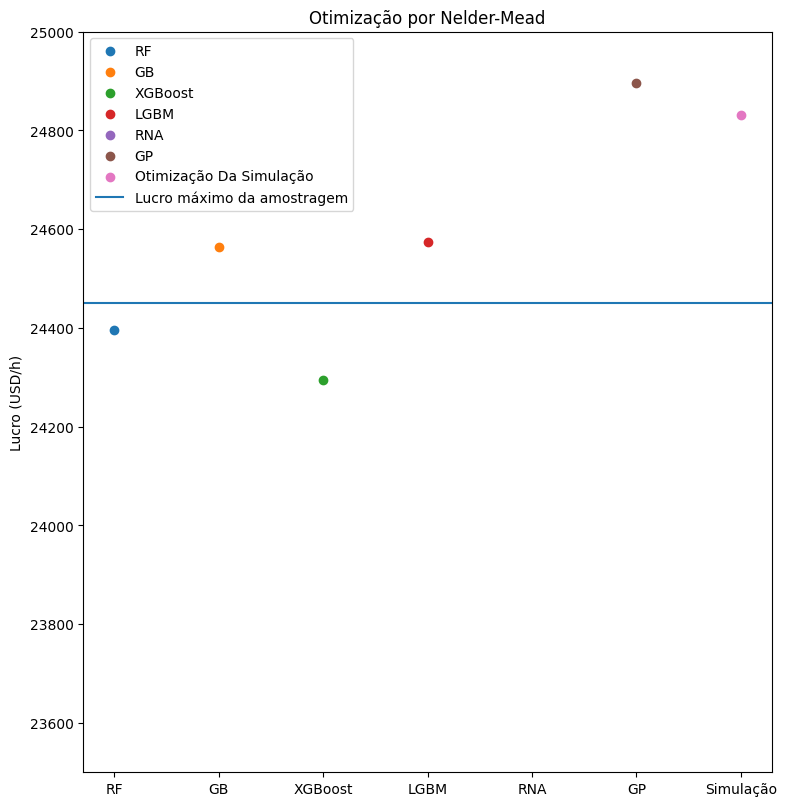

In [33]:
import matplotlib.pyplot as plt
with open(r'C:\Users\LuanNogs\Documents\Ic-Metamodelagem\Nelder_mead_opt.pickle','rb') as file:
    nm_optimization=pickle.load(file) 
with open(r'C:\Users\LuanNogs\Documents\Ic-Metamodelagem\sim_nelder_mead_opt.pickle','rb') as file:
    sim_nm_optimization=pickle.load(file)
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot()
opt_cond={}
opt_profit={}


for name,result in nm_optimization.items():
    opt_cond.update({name:result['Nelder_Mead']})
    opt_profit.update({name:sim_nm_optimization})
models_names=['RF','GB','XGBoost','LGBM','RNA','GP']
opt_cond=dict(zip(models_names,opt_cond.values()))
    # opt_cond.update({result['Condição Ótima {} (PSO)'.format(name)]})
for name,profit in opt_cond.items():

    ax.scatter(name,-opt_cond['{}'.format(name)],label=name )
    # plt.errorbar(name, opt_profit['{}'.format(name)],yerr=[200],fmt='k')
    # ax.annotate('{:.0f}'.format(-profit),[name,-profit+30],size=20)
ax.scatter('Simulação',-sim_nm_optimization['Otimização Simulação (Nelder-Mead)'],label='Otimização Da Simulação')
# ax.annotate('{:.0f}'.format(-sim_nm_optimization['Otimização Simulação (Nelder-Mead)']),['Simulação',-sim_nm_optimization['Otimização Simulação (Nelder-Mead)']+30],size=20)
# plt.errorbar('Simulação', -sim_pso_optimization['Otimização Simulação (PSO)'],yerr=[200],fmt='k')
ax.set_ylim([23500,25000])
ax.axhline(y=24450,label='Lucro máximo da amostragem')
ax.set_ylabel('Lucro (USD/h)')
fig.tight_layout()
ax.set_title('Otimização por Nelder-Mead')
ax.legend()

Heat Map PSO 


In [157]:
import seaborn
import dataframe_image as dfi
import matplotlib.pyplot as plt
with open(r'C:\Users\LuanNogs\Documents\Ic-Metamodelagem\Nelder_mead_opt.pickle','rb') as file:
    nm_optimization=pickle.load(file) 
with open(r'C:\Users\LuanNogs\Documents\Ic-Metamodelagem\sim_nelder_mead_opt.pickle','rb') as file:
    sim_nm_optimization=pickle.load(file)
opt_cond={}
opt_profit={}
for name,result in nm_optimization.items():
    opt_cond.update({name:result['Condição Ótima {} (Nelder-Mead)'.format(name)]})
    opt_profit.update({name:result['Simulação']})
    # opt_cond.update({result['Condição Ótima {} (PSO)'.format(name)]})
        
pso_opt_df=pd.DataFrame(opt_cond).rename({'RandomForestRegressor': 'RF',"GradientBoostingRegressor":"GB","XGBRFRegressor":"XGBoost","LGBMRegressor":"LGBM","GaussianProcessRegressor":"GP"},axis=1).join(pd.DataFrame(-sim_nm_optimization['Condição Ótima Simulação (Nelder-Mead)'],columns=['Simulação']),).rename({0:'Temperatura de Reação (C)',1:'Vazão de H2 (kmol/h)',2:'Razão de Purga',3:'Razão de Reciclo',4:'Volume do Reator (m3)',5: 'Vazão de CO2(kmol/h)'},axis=0).transpose()
pso_opt_df.to_excel(r'nm_opt_df.xlsx')

In [156]:
sim_nm_optimization

{'Otimização Simulação (Nelder-Mead)': -24830.56934461755,
 'Condição Ótima Simulação (Nelder-Mead)': array([2.37863069e+02, 6.39407890e+03, 1.99632052e-03, 1.52683697e+00,
        3.99287013e+01, 4.55655398e+03])}

In [149]:
opt_cond

{'RandomForestRegressor': array([2.38991030e+02, 6.45289436e+03, 2.02283265e-03, 1.51347531e+00,
        4.20407997e+01, 4.52232938e+03]),
 'GradientBoostingRegressor': array([2.39003676e+02, 6.36027104e+03, 2.14829608e-03, 1.65819431e+00,
        3.81241912e+01, 4.50876219e+03]),
 'XGBRFRegressor': array([2.39544913e+02, 6.37609847e+03, 2.02466335e-03, 1.54851429e+00,
        3.85672288e+01, 4.50000000e+03]),
 'LGBMRegressor': array([2.38430279e+02, 6.44426066e+03, 2.01311057e-03, 1.53720439e+00,
        3.85320183e+01, 4.52408780e+03]),
 'RNA': array([2.39997512e+02, 6.49990067e+03, 1.02641042e-03, 1.80000000e+00,
        3.50000000e+01, 5.49918433e+03]),
 'GaussianProcessRegressor': array([2.18846097e+02, 6.37430664e+03, 1.25033967e-02, 1.60158578e+00,
        4.07713896e+01, 4.58484339e+03])}

Heat Map Nelder-Mead

In [ ]:
import matplotlib.pyplot as plt
import seaborn
import dataframe_image as dfi
with open(r'pso_optimization.pickle','rb') as file:
    pso_optimization=pickle.load(file) 
with open(r'sim_pso_opt.pickle','rb') as file:
    sim_pso_optimization=pickle.load(file)
opt_cond={}
opt_profit={}
for name,result in pso_optimization.items():
    opt_cond.update({name:result['Condição Ótima {} (PSO)'.format(name)]})
    opt_profit.update({name:result['Simulação']})
    # opt_cond.update({result['Condição Ótima {} (PSO)'.format(name)]})
        
pso_opt_df=pd.DataFrame(opt_cond).rename({'RandomForestRegressor': 'RF',"GradientBoostingRegressor":"GB","XGBRFRegressor":"XGBoost","LGBMRegressor":"LGBM","GaussianProcessRegressor":"GP"},axis=1).join(pd.DataFrame(sim_pso_optimization['Condição Ótima PSO Simulação'],columns=['Simulação']),).rename({0:'Temperatura de Reação (C)',1:'Vazão de H2 (kmol/h)',2:'Razão de Purga',3:'Razão de Reciclo',4:'Volume do Reator (m3)',5: 'Vazão de CO2(kmol/h)'},axis=0).transpose()
pso_opt_df.to_excel(r'pso_opt_df.xlsx')